In [1]:
%pylab inline
%load_ext Cython

Populating the interactive namespace from numpy and matplotlib


In [2]:
from SuchTree import SuchTree
import seaborn

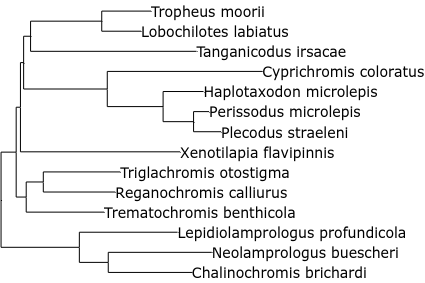

In [3]:
from ete2 import Tree, TreeStyle, NodeStyle, TextFace
from numpy import linspace

ts = TreeStyle()
ts.mode = 'r'
ts.show_leaf_name = True
ts.branch_vertical_margin = 2
ts.scale = 1000
ts.show_leaf_name = False
ts.show_scale = False

nstyle = NodeStyle()
nstyle['size'] = 0

ete_tree = Tree( '../fishpoo/mcgee_trimmed.tree' )

for node in ete_tree.traverse() :
    node.set_style(nstyle)
    if node.is_leaf :
        tf = TextFace( node.name.replace('_',' ').replace('\'','') )
        tf.fsize = 10
        tf.hz_align = 100
        node.add_face( tf, 0 )

ete_tree.render("%%inline", w=120, units="mm", tree_style=ts)

In [4]:
#T = SuchTree( 'SuchTree/tests/test.tree')
T = SuchTree( '../fishpoo/mcgee_trimmed.tree' )

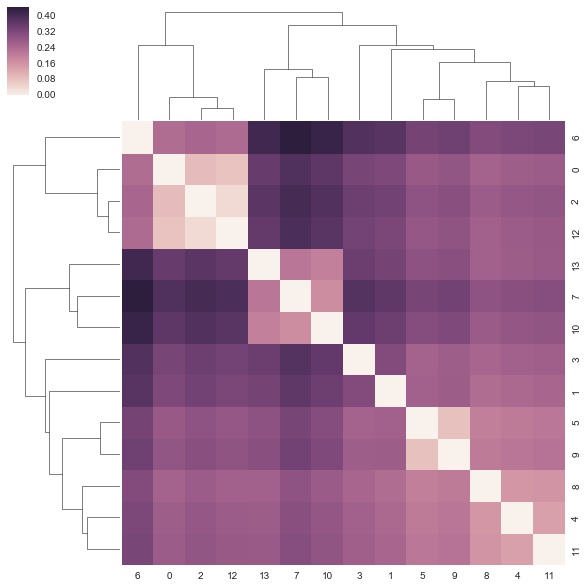

In [5]:
D1 = zeros( ( len(T.leafs),len(T.leafs) ) )
for i,a in enumerate(T.leafs.values()) :
    for j,b in enumerate( T.leafs.values() ) :
        D1[i,j] = T.distance( a, b )
        
seaborn.clustermap(D1)

In [6]:
T1 = SuchTree( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree' )

print 'nodes : %d, leafs : %d' % ( T1.length, len(T1.leafs) )

nodes : 108653, leafs : 54327


In [17]:
%%cython
import cython

def correlation( double[:] x, double[:] y ) :
    try :
        return _correlation( x, y )
    except ZeroDivisionError :
        return 0.0

@cython.boundscheck(False)
cdef double _correlation( double[:] x, double[:] y ) :
    cdef unsigned int n = len(x)
    cdef unsigned long j
    cdef float yt,xt,t,df
    cdef float syy=0.0,sxy=0.0,sxx=0.0,ay=0.0,ax=0.0
    with nogil :
        for j in xrange(n) :
            ax += x[j]
            ay += y[j]
        ax /= n
        ay /= n
        for j in xrange(n) :
            xt=x[j]-ax
            yt=y[j]-ay
            sxx += xt*xt
            syy += yt*yt
            sxy += xt*yt
        return sxy/((sxx*syy)+1.0e-20)**(0.5)

In [8]:
import pandas as pd

def foundon( df  ) :
    s = df.unstack()
    return s[ s > 0].to_dict().keys()

links = pd.read_csv( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_host_count_table.tsv', 
                    sep='\t', index_col='Host')
links.index = map( lambda x : x.replace(' ','_'), links.index )

len(foundon(links))

149692

In [14]:
from itertools import combinations

N = len(list(T1.get_internal_nodes()))

sfael = dict( zip( T1.leafs.values(), T1.leafs.keys() ) )

def paired_distances( id ) :
    clade = map( lambda x : sfael[x], T1.get_leafs(id) )
    if len(clade) > 100 : raise Exception( 'clade too big', id )
    if len(clade) < 6   :   raise Exception( 'clade too small', id )
    l = foundon(links[clade])
    if len(l) < 10 : raise Exception( 'too few links', id )
    gpairs, hpairs = [],[]
    for (g1,h1),(g2,h2) in combinations( l, 2 ) :
        gpairs.append( (g1,g2) )
        hpairs.append( (h1,h2) )
    gd = T1.distances_by_name( gpairs )
    hd = T.distances_by_name( hpairs )
    return { 'length' : len(clade), 'n_links' : len(l), 'guest distances' : gd, 'host distances' : hd }

In [24]:
from threading import Thread
from Queue import Queue
import pyprind

n = 2
m = 12

work_q = Queue()
done_q = Queue()

progbar = pyprind.ProgBar( N, monitor=True, title='computing distances...' )

for id in T1.get_internal_nodes() :
    work_q.put( id )

for i in xrange( n ) :
    work_q.put( 'STOP' )

def worker( work_q, done_q ) :
    for id in iter( work_q.get, 'STOP' ) :
        try :
            result = paired_distances( id )
            row = {}
            pr,pp = correlation( result['guest distances'], result['host distances'] ),0
            sr,sp = 0,0
            row[ 'pearsonr' ] = pr
            row[ 'pearsonp' ] = pp
            row[ 'spearmanr' ] = sr
            row[ 'spearmanp' ] = sp
            row[ 'length' ] = result[ 'length' ]
            row[ 'n_links' ] = result[ 'n_links' ]
            row[ 'id' ] = id
            done_q.put( row )
            progbar.update()
        except Exception as error :
            done_q.put( error )
            progbar.update()
            continue
    return True

threads = []

for i in xrange( n ) :
    thread = Thread( target=worker, args=( work_q, done_q ) )
    thread.start()
    threads.append( thread )
    
for thread in threads :
    thread.join()

done_q.put( 'STOP' )

computing distances...
0%                          100%
[############################# ] | ETA: 00:00:08

In [25]:
results = filter( lambda x : type(x) != Exception, iter( done_q.get, 'STOP' ) )

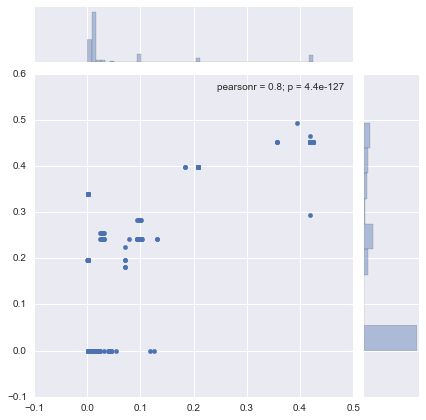

In [26]:
result = paired_distances( sorted(results, key=lambda x : x['pearsonr'] )[-1]['id'] )
seaborn.jointplot(result['guest distances'], result['host distances'] )

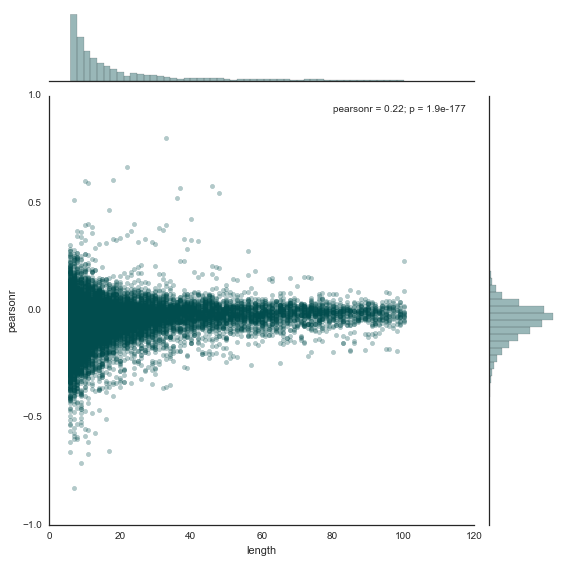

In [27]:
R = pd.DataFrame( results )

with seaborn.axes_style("white"):
    seaborn.jointplot( 'length', 'pearsonr', data=R, color=seaborn.xkcd_rgb['dark teal'], alpha=0.3, size=8 )